In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Geohash all trip records

In [2]:
df = pd.read_csv('temp/data/taxi_tripdata_2016-05.csv',usecols=['pickup_geohash'])
pickup = df.groupby(['pickup_geohash']).pickup_geohash.count()
pickup.head()

pickup_geohash
dr5qgz5    5
dr5qgz7    1
dr5qgz8    2
dr5qgzc    1
dr5qgze    2
Name: pickup_geohash, dtype: int64

In [3]:
df = pd.read_csv('temp/data/taxi_tripdata_2016-05.csv', usecols=['dropoff_geohash'])
dropoff = df.groupby(['dropoff_geohash']).dropoff_geohash.count()
dropoff.head()

dropoff_geohash
dr5qgru    1
dr5qgrv    1
dr5qgry    1
dr5qgxm    1
dr5qgxs    2
Name: dropoff_geohash, dtype: int64

In [4]:
import Geohash

demand = pd.concat([pickup, dropoff], axis=1).fillna(0)
demand = demand.rename(columns={
    'pickup_geohash':'total_pickup',
    'dropoff_geohash':'total_dropoff'
})
geolats = []
geolons = []
for s in demand.index:
    lat, lon, _, _ = Geohash.decode_exactly(s)
    geolats.append(float(lat))
    geolons.append(float(lon))
demand['lat'] = geolats
demand['lon'] = geolons
demand = demand.reset_index().rename(columns={'index':'geohash'})
demand.head()

,geohash,total_pickup,total_dropoff,lat,lon
0,dr5qgru,0,1,40.604782,-74.030685
1,dr5qgrv,0,1,40.604782,-74.029312
2,dr5qgry,0,1,40.604782,-74.027939
3,dr5qgxm,0,1,40.602036,-74.018326
4,dr5qgxs,0,2,40.603409,-74.019699


In [5]:
demand = demand[(demand.total_pickup>5)|(demand.total_dropoff>5)]

## Analyze # of pickup/dropoff by zones

In [6]:
from mapping_utils import plot_overmap
import geopandas as gpd

nyc = gpd.read_file("temp/data/taxi_zones/taxi_zones.shp").to_crs('+proj=latlon')
nyc = nyc[(nyc.borough != 'EWR')&(nyc.borough != 'Staten Island')]

In [7]:
import shapely
import rtree

def assign_zone(loc, gdf):
    df = gpd.GeoDataFrame(loc.copy(), crs="+proj=latlon")
    df["geometry"] = [shapely.geometry.Point(lon, lat)for lat, lon in loc.values]
    df = gpd.sjoin(df, gdf[["geometry"]], how="inner", op="within")    
    return df.index_right

In [8]:
demand['taxi_zone'] = assign_zone(demand[['lat', 'lon']], nyc)
demand = demand.dropna()
demand.head()

,geohash,total_pickup,total_dropoff,lat,lon,taxi_zone
7,dr5qgxx,0,8,40.603409,-74.015579,10
8,dr5qgxy,0,8,40.604782,-74.016953,10
9,dr5qgxz,0,9,40.604782,-74.015579,10
14,dr5qgz7,1,19,40.602036,-74.010086,10
15,dr5qgz8,2,11,40.603409,-74.014206,10


## Remove taxi zones with low pickup/dropoff

In [9]:
demand_by_zone = demand.groupby(['taxi_zone'])[['total_pickup', 'total_dropoff']].sum()
demand_by_zone = demand_by_zone[
    (demand_by_zone.total_pickup>300)
    | (demand_by_zone.total_dropoff>300)]

In [10]:
nyc['total_pickup'] = np.sqrt(demand_by_zone.total_pickup)
nyc['total_dropoff'] = np.sqrt(demand_by_zone.total_dropoff)

/Users/odatakuma/anaconda/lib/python2.7/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


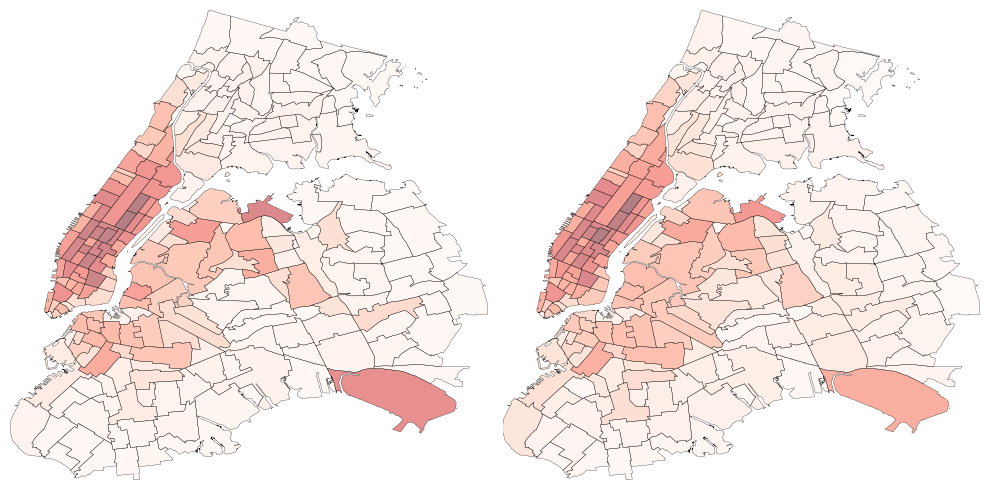

In [11]:
plt.clf()
fig = plt.figure(figsize=(10, 5), dpi=10)
ax1 = fig.add_subplot(121, axisbg='w', frame_on=False)
ax1.set_xticks([])
ax1.set_yticks([])
nyc.dropna().plot(column='total_pickup', cmap="Reds", axes=ax1, linewidth=0.2)
ax2 = fig.add_subplot(122, axisbg='w', frame_on=False)
ax2.set_xticks([])
ax2.set_yticks([])
nyc.dropna().plot(column='total_dropoff', cmap="Reds", axes=ax2, linewidth=0.2)
plt.tight_layout();

In [12]:
taxi_zones = demand_by_zone.index
demand = demand[[zone in taxi_zones for zone in demand.taxi_zone]]

In [13]:
demand.to_csv('data/geohash.csv', index=False)

## Tag taxi zone to all trip records

In [14]:
zones = pd.read_csv("data/geohash.csv")
zones.head()

,geohash,total_pickup,total_dropoff,lat,lon,taxi_zone
0,dr5qgxx,0,8,40.603409,-74.015579,10
1,dr5qgxy,0,8,40.604782,-74.016953,10
2,dr5qgxz,0,9,40.604782,-74.015579,10
3,dr5qgz7,1,19,40.602036,-74.010086,10
4,dr5qgz8,2,11,40.603409,-74.014206,10


In [15]:
hash2zone = zones.set_index('geohash').taxi_zone.astype(int).to_dict()

In [16]:
df = pd.read_csv('temp/data/taxi_tripdata_2016-05.csv',
                 usecols=[
                     'pickup_geohash',
                     'dropoff_geohash'
                 ]
                )
df.head()

,pickup_geohash,dropoff_geohash
0,dr5rz4r,dr5rz2t
1,dr5rsg5,dr5rtk7
2,dr72j1h,dr5rtjs
3,dr5rz63,dr5rw3c
4,dr5rtj6,dr5rsg7


In [17]:
%%time
pickup_zone = df.pickup_geohash.map(lambda x: hash2zone.get(x, -1))

CPU times: user 8.4 s, sys: 228 ms, total: 8.62 s
Wall time: 8.8 s


In [18]:
%%time
dropoff_zone = df.dropoff_geohash.map(lambda x: hash2zone.get(x, -1))

CPU times: user 7.56 s, sys: 166 ms, total: 7.73 s
Wall time: 7.77 s


In [19]:
df = pd.read_csv('temp/data/taxi_tripdata_2016-05.csv')
df['pickup_zone'] = pickup_zone
df['dropoff_zone'] = dropoff_zone
df.head()

,request_id,date,dayofweek,dropoff_latitude,dropoff_longitude,hour,minute,pickup_latitude,pickup_longitude,second,trip_distance,trip_time,great_circle_distance,pickup_geohash,dropoff_geohash,pickup_zone,dropoff_zone
0,0,1,6,40.730099,-73.983986,0,0,40.768040,-73.985901,0,3.60,17.516667,4221,dr5rz4r,dr5rz2t,172,55
1,1,1,6,40.744633,-73.980995,0,0,40.741573,-73.993073,0,1.09,7.016667,1072,dr5rsg5,dr5rtk7,255,79
2,2,1,6,40.733002,-74.002258,0,0,40.684601,-73.991943,0,4.21,19.783333,5451,dr72j1h,dr5rtjs,74,111
3,3,1,6,40.765469,-73.975700,0,0,40.744751,-73.991577,0,1.68,7.516667,2663,dr5rz63,dr5rw3c,172,197
4,4,1,6,40.737564,-73.997498,0,0,40.740192,-74.005280,0,0.56,6.650000,717,dr5rtj6,dr5rsg7,254,255


In [20]:
df.to_csv('temp/data/taxi_tripdata_2016-05.csv', index=False)

## Create Dataset for demand prediction

In [2]:
df = pd.read_csv('temp/data/taxi_tripdata_2016-05.csv',
                 usecols=[
                     'pickup_zone',
                     'dropoff_zone',
                     'pickup_geohash',
                     'hour',
                     'dayofweek',
                     'date'
                 ], dtype={
                     'pickup_zone':np.int16,
                     'dropoff_zone':np.int16,
                     'hour':np.int16,
                     'dayofweek':np.int16,
                     'date':np.int16
                 }
                )
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12912396 entries, 0 to 12912395
Data columns (total 6 columns):
date              int16
dayofweek         int16
hour              int16
pickup_geohash    object
pickup_zone       int16
dropoff_zone      int16
dtypes: int16(5), object(1)
memory usage: 320.2+ MB


In [3]:
df = df[(df.pickup_zone>=0)&(df.dropoff_zone>=0)]
demand = df.reset_index().groupby(['date', 'dayofweek', 'hour', 'pickup_geohash']).agg({
    'index':'count'
}).rename(columns={'index':'count'}).reset_index()
demand['datehour'] = (demand.date-1)*24+demand.hour
demand.head()

,date,dayofweek,hour,pickup_geohash,count,datehour
0,1,6,0,dr5qgz8,1,0
1,1,6,0,dr5qupn,1,0
2,1,6,0,dr5qupr,1,0
3,1,6,0,dr5qvrs,1,0
4,1,6,0,dr5r53c,1,0


In [4]:
demand_pivot = demand.pivot(index='datehour', columns='pickup_geohash', values='count')
demand_pivot = demand_pivot.fillna(0)
demand_pivot.head()

pickup_geohash,dr5qgz7,dr5qgz8,dr5qgzc,dr5qgze,dr5qgzr,dr5qgzu,dr5qgzw,dr5qup0,dr5qup3,dr5qup4,...,dr78818,dr7881c,dr7881d,dr7881f,dr7881g,dr7882y,dr78842,dr78843,dr78848,dr78849
datehour,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
del df

In [6]:
demand_pivot['date'] = demand_pivot.index.values/24 + 1
demand_pivot['dayofweek'] = (demand_pivot.date+5)%7
demand_pivot['hour'] = demand_pivot.index.values%24
demand = pd.melt(demand_pivot, id_vars=['date', 'dayofweek', 'hour'])
demand = demand.rename(columns={'pickup_geohash':'geohash', 'value':'demand'})
demand.head()

,date,dayofweek,hour,geohash,demand
0,1,6,0,dr5qgz7,0
1,1,6,1,dr5qgz7,0
2,1,6,2,dr5qgz7,0
3,1,6,3,dr5qgz7,0
4,1,6,4,dr5qgz7,0


In [7]:
demand = demand.sort_values(by=['date', 'hour'])
zones = pd.read_csv("data/geohash.csv")
demand =demand.merge(zones[['geohash', 'lat', 'lon']], how='left', on='geohash')
demand.head()

,date,dayofweek,hour,geohash,demand,lat,lon
0,1,6,0,dr5qgz7,0,40.602036,-74.010086
1,1,6,0,dr5qgz8,1,40.603409,-74.014206
2,1,6,0,dr5qgzc,0,40.604782,-74.012833
3,1,6,0,dr5qgze,0,40.603409,-74.010086
4,1,6,0,dr5qgzr,0,40.602036,-74.004593


In [8]:
demand.to_csv('temp/data/demand_dataset.csv', index=False)